In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Import Library
import random
import warnings
import seaborn as sns # statistical visualization
import matplotlib.pyplot as plt #plot
import scipy
from scipy import stats
from scipy.stats import norm, skew, boxcox
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler,RobustScaler
%matplotlib inline

In [3]:
# Load data
Train_Path = "../input/titanic/train.csv"
Test_Path = "../input/titanic/test.csv"
titanic_train = pd.read_csv(Train_Path).sort_values(by="PassengerId")
titanic_test = pd.read_csv(Test_Path).sort_values(by="PassengerId")
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
titanic_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
print("Train_dataset Shape:",titanic_train.shape)

print("Test_dataset Shape:",titanic_test.shape)

Train_dataset Shape: (891, 12)
Test_dataset Shape: (418, 11)


In [7]:
women = titanic_train.loc[titanic_train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)
men = titanic_train.loc[titanic_train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)
print("% of women who survived:", rate_women)
print("% of men who survived:", rate_men)


% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


## Seed Function

** It is used to save the state of a random function, so that it can generate same random numbers on multiple executions of the code on the same machine or on different machines (for a specific seed value). The seed value is the previous value number generated by the generator. For the first time when there is no previous value, it uses current system time.
** random() function is used to generate random numbers in Python. Not actually random, rather this is used to generate pseudo-random numbers. That implies that these randomly generated numbers can be determined.

> random() function generates numbers for some values. This value is also called seed value.

>  random module is imported
import random 
for i in range(2):
  
    # Any number can be used in place of '0'.
    random.seed(0)
  
    # Generated random number will be between 1 to 1000.
    print(random.randint(1, 1000))  
> 200
> 200


******************************************************
import random 
random.seed(2)
print(random.randint(1, 1000))
print(random.randint(1, 1000))
> 244
> 144

** To keep the reproducibility same  we will use SEED = 2022

    os.environ['PYTHONHASHSEED'] = str(seed)
    

## Use of Seed function


In [8]:
Set_seed = 2
def seed_all(seed=Set_seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # keep reproducibility same
    np.random.seed(seed)

seed_all()

## Histogram : Check for Independent, dependent  and Redundant variable
**Pre-Process check**

In [9]:
def plot_hist(df,variable):
    print("min {} : {} ".format(variable, min(df[variable])))
    print("max {} : {}".format(variable, max(df[variable])))
    
    plt.figure(figsize=(6,2))
    plt.hist(df[variable])
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist ".format(variable))
    plt.show()

min Pclass : 1 
max Pclass : 3


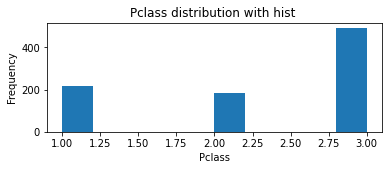

min Age : 0.42 
max Age : 80.0


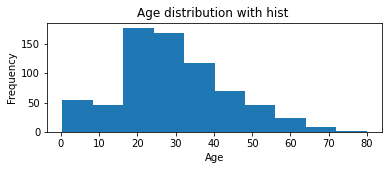

min SibSp : 0 
max SibSp : 8


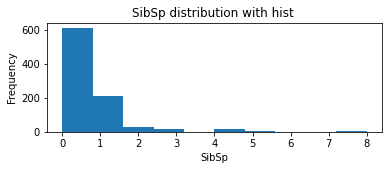

min Parch : 0 
max Parch : 6


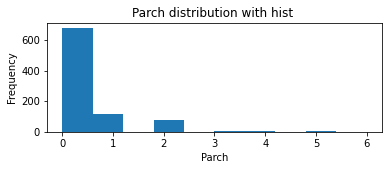

min Fare : 0.0 
max Fare : 512.3292


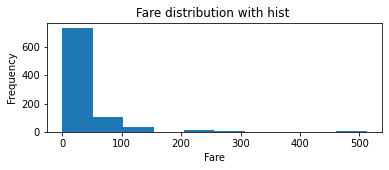

In [10]:

train = pd.read_csv(Train_Path)

str_list = [] 
num_list = []
float_list = []
for colname, colvalue in train.iteritems():
    if colname == "PassengerId" or colname == "Survived":
        continue

    if type(colvalue[1]) == str:
        str_list.append(colname)
    else:
        num_list.append(colname)
    
for col in num_list:
   
    plot_hist(titanic_train,col)

In [11]:
stat_out = titanic_train.describe()
stat_out.loc['var'] = titanic_train.var().tolist()
stat_out.loc['skew'] = titanic_train.skew().tolist()
stat_out.loc['kurt'] = titanic_train.kurtosis().tolist()
stat_out

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200
var,66231.000000,0.236772,0.699015,211.019125,1.216043,0.649728,2469.436846
skew,0.000000,0.478523,-0.630548,0.389108,3.695352,2.749117,4.787317


## Data Pre-Process


In [12]:
# Delete columns
titanic_train.drop(labels=["Ticket", "Cabin","Name"], axis=1, inplace=True)
titanic_test.drop(labels=["Ticket", "Cabin","Name"], axis=1, inplace=True)
titanic_train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [13]:
titanic_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [14]:
##checking data types of columns
titanic_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object

In [15]:
# Replace 'NAN' value by median value for 'int' 'type and mode for 'str' type
# train data
titanic_train["Age"].fillna(titanic_train["Age"].median(), inplace=True) # age is postively skewed
titanic_train["Fare"].fillna(titanic_train["Fare"].median(), inplace=True) # fare is postively skewed
titanic_train["Embarked"].fillna(titanic_train["Embarked"].mode()[0], inplace=True)
# test data
titanic_test["Age"].fillna(titanic_test["Age"].median(), inplace=True)
titanic_test["Fare"].fillna(titanic_test["Fare"].median(), inplace=True)
titanic_test["Embarked"].fillna(titanic_test["Embarked"].mode()[0], inplace=True)
titanic_train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
5,6,0,3,male,28.0,0,0,8.4583,Q
6,7,0,1,male,54.0,0,0,51.8625,S
7,8,0,3,male,2.0,3,1,21.0750,S
8,9,1,3,female,27.0,0,2,11.1333,S
9,10,1,2,female,14.0,1,0,30.0708,C


In [16]:
# After No Null operation
titanic_train.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [17]:
titanic_test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [18]:

titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 29.4+ KB


## Analysis of Passengers Class

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Pclass', ylabel='count'>

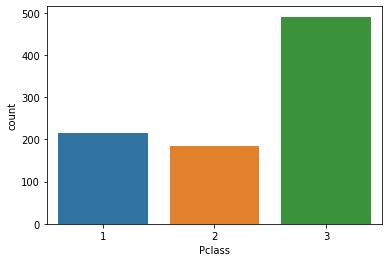

In [19]:
# Passenger Class
sns.countplot(titanic_train["Pclass"])

 Passenger of class 3 is the highest among all.
 Out of 3 classes, we analyze  the number people survived most based on age and sex.

In [20]:
# age classification
titanic_train["Age_Class"] = pd.cut(titanic_train.Age, 
                                    [0,20,40,60, np.inf], labels=['Kid','Young','Adult',"Senior"])
titanic_test["Age_Class"] = pd.cut(titanic_test.Age, 
                                    [0,20,40,60, np.inf], labels=['Kid','Young','Adult',"Senior"])
titanic_test.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Class
0,892,3,male,34.5,0,0,7.8292,Q,Young
1,893,3,female,47.0,1,0,7.0000,S,Adult
2,894,2,male,62.0,0,0,9.6875,Q,Senior
3,895,3,male,27.0,0,0,8.6625,S,Young
4,896,3,female,22.0,1,1,12.2875,S,Young
5,897,3,male,14.0,0,0,9.2250,S,Kid
6,898,3,female,30.0,0,0,7.6292,Q,Young
7,899,2,male,26.0,1,1,29.0000,S,Young
8,900,3,female,18.0,0,0,7.2292,C,Kid
9,901,3,male,21.0,2,0,24.1500,S,Young


In [21]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Sex          418 non-null    object  
 3   Age          418 non-null    float64 
 4   SibSp        418 non-null    int64   
 5   Parch        418 non-null    int64   
 6   Fare         418 non-null    float64 
 7   Embarked     418 non-null    object  
 8   Age_Class    418 non-null    category
dtypes: category(1), float64(2), int64(4), object(2)
memory usage: 30.0+ KB


In [22]:
titanic_train["Age_Class"].replace({"Kid":0,"Young":1,"Adult":2,"Senior":3 },inplace=True)  ## label encoding
titanic_test["Age_Class"].replace({"Kid":0,"Young":1,"Adult":2,"Senior":3 },inplace=True)  ## label encoding
titanic_test.head(7)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Class
0,892,3,male,34.5,0,0,7.8292,Q,1
1,893,3,female,47.0,1,0,7.0000,S,2
2,894,2,male,62.0,0,0,9.6875,Q,3
3,895,3,male,27.0,0,0,8.6625,S,1
4,896,3,female,22.0,1,1,12.2875,S,1
5,897,3,male,14.0,0,0,9.2250,S,0
6,898,3,female,30.0,0,0,7.6292,Q,1


In [23]:

titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
 8   Age_Class    418 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 32.7+ KB


In [24]:

titanic_test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Age_Class      0
dtype: int64

In [25]:
titanic_train["Embarked"].replace({"S":0,"Q":1,"C":2},inplace=True)  ## label encoding
titanic_test["Embarked"].replace({"S":0,"Q":1,"C":2 },inplace=True)  ## label encoding
titanic_train.head(7)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Class
0,1,0,3,male,22.0,1,0,7.2500,0,1
1,2,1,1,female,38.0,1,0,71.2833,2,1
2,3,1,3,female,26.0,0,0,7.9250,0,1
3,4,1,1,female,35.0,1,0,53.1000,0,1
4,5,0,3,male,35.0,0,0,8.0500,0,1
5,6,0,3,male,28.0,0,0,8.4583,1,1
6,7,0,1,male,54.0,0,0,51.8625,0,2


In [26]:
titanic_test.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Class
0,892,3,male,34.5,0,0,7.8292,1,1
1,893,3,female,47.0,1,0,7.0000,0,2
2,894,2,male,62.0,0,0,9.6875,1,3
3,895,3,male,27.0,0,0,8.6625,0,1
4,896,3,female,22.0,1,1,12.2875,0,1
5,897,3,male,14.0,0,0,9.2250,0,0
6,898,3,female,30.0,0,0,7.6292,1,1
7,899,2,male,26.0,1,1,29.0000,0,1
8,900,3,female,18.0,0,0,7.2292,2,0
9,901,3,male,21.0,2,0,24.1500,0,1


In [27]:
titanic_test.shape

(418, 9)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Age_Class', ylabel='count'>

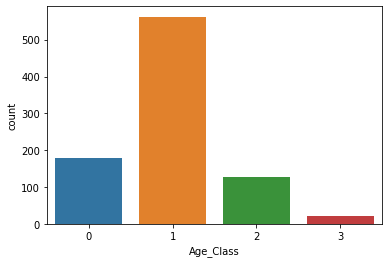

In [28]:
sns.countplot(titanic_train["Age_Class"])

In [29]:
titanic_train.groupby(["Age_Class","Sex"])["Survived"].value_counts()

Age_Class  Sex     Survived
0          female  1            53
                   0            24
           male    0            73
                   1            29
1          female  1           143
                   0            46
           male    0           311
                   1            62
2          female  1            34
                   0            11
           male    0            67
                   1            16
3          female  1             3
           male    0            17
                   1             2
Name: Survived, dtype: int64

In [30]:
titanic_train.groupby(["Age_Class","Pclass"])["Survived"].value_counts()

Age_Class  Pclass  Survived
0          1       1            17
                   0             4
           2       1            26
                   0             9
           3       0            84
                   1            39
1          1       1            80
                   0            39
           2       0            67
                   1            48
           3       0           251
                   1            77
2          1       1            36
                   0            26
           2       0            19
                   1            12
           3       0            33
                   1             2
3          1       0            11
                   1             3
           2       0             2
                   1             1
           3       0             4
                   1             1
Name: Survived, dtype: int64

In [31]:
titanic_train["Sex"].replace({"male":0,"female":1},inplace=True)  ## label encoding
titanic_test["Sex"].replace({"male":0,"female":1},inplace=True)  ## label encoding
titanic_train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Class
0,1,0,3,0,22.0,1,0,7.2500,0,1
1,2,1,1,1,38.0,1,0,71.2833,2,1
2,3,1,3,1,26.0,0,0,7.9250,0,1
3,4,1,1,1,35.0,1,0,53.1000,0,1
4,5,0,3,0,35.0,0,0,8.0500,0,1


In [32]:
titanic_test.head(5)
titanic_test.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Age_Class'],
      dtype='object')

In [33]:
# Splitting the dataset on training and validating
from sklearn.model_selection import train_test_split

X = titanic_train.drop("Survived", axis=1)
y = titanic_train["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [35]:
# Create dictionary of models
models = {"LinearSVC": LinearSVC(),
          "KNN": KNeighborsClassifier(),
          "SVC": SVC(),
          "LogisticRegression": LogisticRegression(),
          "RandomForestClassifier": RandomForestClassifier(),
          "XGBoost": xgb.XGBClassifier(use_label_encoder=False)}


# Create an empty dictionary for results
results = {}

In [36]:
# Fit and score each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    results[model_name] = model.score(X_val, y_val)

# View the results
results

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'LinearSVC': 0.6368715083798883,
 'KNN': 0.659217877094972,
 'SVC': 0.5977653631284916,
 'LogisticRegression': 0.7932960893854749,
 'RandomForestClassifier': 0.8268156424581006,
 'XGBoost': 0.7932960893854749}

In [37]:
# Tune hyperparams of KNN
# Create dict for KNN params
param_knn = {'n_neighbors': [5, 7, 8, 9, 10, 12, 15, 20],
             'weights': ['uniform', 'distance'],
             'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Setup the grid search
grid_knn = GridSearchCV(KNeighborsClassifier(),
                        param_knn,
                        cv=5)

# Fit the grid search to the data
grid_knn.fit(X_train, y_train)

# Find the best parameters
grid_knn.best_params_, grid_knn.best_score_

({'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'uniform'},
 0.6670737712991234)

In [38]:
# Check score on validating data
grid_knn.best_estimator_.score(X_val, y_val)

0.6759776536312849

In [39]:
preds = grid_knn.best_estimator_.predict(titanic_test)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [40]:
passenger_id=titanic_test["PassengerId"]

d = { 'PassengerId': passenger_id,'Survived': preds} 
     
prediction_df = pd.DataFrame(d)
prediction_df.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,0
9,901,0


In [41]:
# Check all metrics on full data
print(f"Accuracy {np.mean(cross_val_score(grid_knn.best_estimator_, X, y, cv=5, scoring='accuracy'))}")
print(f"Recall {np.mean(cross_val_score(grid_knn.best_estimator_, X, y, cv=5, scoring='recall'))}")
print(f"Precision {np.mean(cross_val_score(grid_knn.best_estimator_, X, y, cv=5, scoring='precision'))}")
print(f"F1 {np.mean(cross_val_score(grid_knn.best_estimator_, X, y, cv=5, scoring='f1'))}")

Accuracy 0.581325717155232
Recall 0.28499573742540496
Precision 0.6032268632268633
F1 0.28945782620759386


In [42]:
# Tune hyperparams of RandomForestClassifier
# Create dict for RandomForestClassifier params
param_RFC = {'n_estimators': [i for i in range(1, 101, 5)],
             'max_depth': [i for i in range(1, 31, 3)]}

# Setup the grid search
grid_RFC = GridSearchCV(RandomForestClassifier(random_state=42),
                        param_RFC,
                        cv=5)

# Fit the grid search to the data
grid_RFC.fit(X_train, y_train)

# Find the best parameters
grid_RFC.best_params_, grid_RFC.best_score_

({'max_depth': 7, 'n_estimators': 96}, 0.8257854821235103)

In [43]:
preds = grid_RFC.best_estimator_.predict(titanic_test)
preds

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [44]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    int64  
 8   Age_Class    418 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 32.7 KB


In [45]:
passenger_id=titanic_test["PassengerId"]

d = { 'PassengerId': passenger_id,'Survived': preds} 
     
prediction_df = pd.DataFrame(d)
prediction_df.head(10)
  

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [46]:
# Check right shape of test data
X_train.shape, titanic_test.shape

((712, 9), (418, 9))

In [47]:
# Tune hyperparams of XGBClassifier
# Create dict for XGBClassifier params
param_xgb = {
    "max_depth": [3, 5, 9],
    "learning_rate": [0.01, 0.1, 0.3, 1],
    "gamma": [0,  1, 3],
    "reg_alpha": [0, 1, 10],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 5]
}

# Setup the grid search
grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42, use_label_encoder=False), 
                        param_xgb,
                        cv=5)

# Fit the grid search to the data
grid_xgb.fit(X_train, y_train)

# Find the best parameters
grid_xgb.best_params_, grid_xgb.best_score_

({'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 3,
  'reg_alpha': 0,
  'reg_lambda': 1,
  'scale_pos_weight': 1},
 0.8370432384516893)

In [48]:
# Check all metrics on full data
print(f"Accuracy {np.mean(cross_val_score(grid_xgb.best_estimator_, X, y, cv=5, scoring='accuracy'))}")
print(f"Recall {np.mean(cross_val_score(grid_xgb.best_estimator_, X, y, cv=5, scoring='recall'))}")
print(f"Precision {np.mean(cross_val_score(grid_xgb.best_estimator_, X, y, cv=5, scoring='precision'))}")
print(f"F1 {np.mean(cross_val_score(grid_xgb.best_estimator_, X, y, cv=5, scoring='f1'))}")

Accuracy 0.7779612077082418
Recall 0.5450980392156863


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision 0.6565520066602614
F1 0.5931345656927052


In [49]:
# Predict on test data
preds1 = grid_xgb.best_estimator_.predict(titanic_test)

In [50]:
passenger_id=titanic_test["PassengerId"]

d1 = { 'PassengerId': passenger_id,'Survived': preds1} 
     
prediction_df = pd.DataFrame(d1)
prediction_df.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
